<a href="https://colab.research.google.com/github/Nicolas-Saade/TensorflowDeepImageNet/blob/main/Transfer_Learning_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Sep  7 17:19:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Pre Model Creation

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf

# Deep Learning API for creating Neural Networks (Runs on TensorFlow)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import math
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import pathlib
import os
import zipfile
import io
from google.colab import files
from google.colab import drive

# Mounting Google drive to load training and testing data:
drive.mount('/content/gdrive')

#Extracting files and directory structure for training and test data:
my_files = zipfile.ZipFile("/content/gdrive/MyDrive/data/20FoodImages 2.zip")
my_files.extractall()
my_files.close()

# A data augmentation pipeline, that will be added as an extra layer to one of our models
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
  layers.RandomTranslation(0.2, 0.2),
  layers.RandomBrightness(0.2),
])

# Function grabs a random image from a directory
def display_random_image(dir, class_type):
    img_dir = dir + "/" + class_type
    files = os.listdir(img_dir)
    img_name = random.choice(files)
    img = mpimg.imread(img_dir + "/" + img_name)
    plt.imshow(img)
    plt.title(class_type)
    plt.axis("off");
    print(f"Image shape: {img.shape}")

# Image normalization and resizing
def normalize_and_resize(img_loc):
  #Loading and decoding the image into a tensor from the string input bytes.
  my_img = tf.io.read_file(img_loc)
  my_img = tf.image.decode_image(my_img)

  my_img = tf.image.resize(my_img, size=[256, 256]) #resizes the image to the specified size
  my_img = my_img/255. # Normalizes the pixel values to the range [0.1]
  return my_img

# Setup train & test directories
train_dir = "/content/20FoodImages/train/"
validation_dir = "/content/20FoodImages/test/"

# Normalize from RGB values from 0 to 255 to 0 to 1
train_IDG = ImageDataGenerator(rescale=1/255) #Real time image augmentation and batching using Keras
validation_IDG = ImageDataGenerator(rescale=1/255)

# Load data and turn it into batches
train_data = train_IDG.flow_from_directory( #this function will perform the normalization defined using hte ImageDataGenerator when reading immediately from the directory
    train_dir, #parent directory path
    target_size=(256, 256), # target size of input image
    batch_size=32, #32 is some sort of magical number
    class_mode="categorical" # Multi-class instead of binary
  )

val_data = validation_IDG.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode="categorical"
  )

# Get the total number of batches of 32 images
len(train_data), 47000/32

print("Hello world", len(train_data))

apple_pie = normalize_and_resize("/content/20FoodImages/test/apple_pie/101251.jpg")
apple_pie

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 46400 images belonging to 58 classes.
Found 11600 images belonging to 58 classes.
Hello world 1450


<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.25784314, 0.20686275, 0.07156863],
        [0.26078433, 0.20980392, 0.07892157],
        [0.2622549 , 0.21078432, 0.08382353],
        ...,
        [0.3372549 , 0.38578433, 0.30882353],
        [0.30735293, 0.3602941 , 0.27009803],
        [0.26911765, 0.32794118, 0.22892156]],

       [[0.24901961, 0.20392157, 0.09411765],
        [0.24313726, 0.19803922, 0.09411765],
        [0.24460784, 0.19901961, 0.09901961],
        ...,
        [0.4764706 , 0.5083333 , 0.44411764],
        [0.43039215, 0.4617647 , 0.39313725],
        [0.39068627, 0.42205882, 0.34754902]],

       [[0.2514706 , 0.20833333, 0.12598039],
        [0.2514706 , 0.20833333, 0.13186274],
        [0.25196078, 0.21029411, 0.13529412],
        ...,
        [0.65294117, 0.67058825, 0.6156863 ],
        [0.6127451 , 0.6284314 , 0.5735294 ],
        [0.5377451 , 0.5534314 , 0.4970588 ]],

       ...,

       [[0.39019608, 0.25196078, 0.05343137],
        [0.40

Image shape: (512, 512, 3)


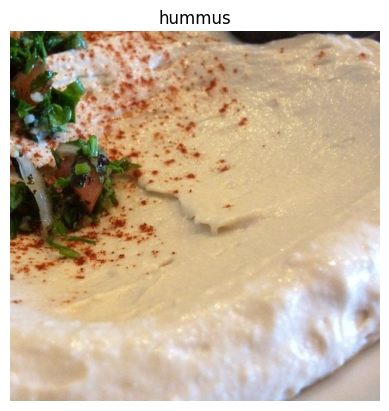

In [ ]:
#Displaying Random Image to peek into dataset
display_random_image("/content/20FoodImages/train",
                    "hummus")

# Creating fisrt CNN without data augmentation.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1450/1450 ━━━━━━━━━━━━━━━━━━━━ 232s 154ms/step - accuracy: 0.0498 - loss: 3.9374 - val_accuracy: 0.1201 - val_loss: 3.6066
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1450/1450 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1875 - val_loss: 3.4181
Epoch 3/15
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 196s 135ms/step - accuracy: 0.2302 - loss: 3.1254 - val_accuracy: 0.1336 - val_loss: 3.6090
Epoch 4/15
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1250 - val_loss: 3.3853
Epoch 5/15
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 193s 129ms/step - accuracy: 0.5914 - loss: 1.5903 - val_accuracy: 0.1064 - val_loss: 4.8870
Epoch 6/15
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.2133
Epoch 7/15
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 197s 126ms/step - accuracy: 0.9148 - loss: 0.3465 - val_accuracy: 0.0862 - val_loss: 8.6438
Epoch 8/15
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1250 - val_loss: 6.6272
Epoch 9/15
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 187s 1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 254, 254, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 252, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 252, 252, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 124, 124, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 122, 122, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 122, 122, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 37210)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 58)                  │       2,158,238 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 58)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,483,746 (24.73 MB)

 Trainable params: 2,161,248 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,322,498 (16.49 MB)

Model evaluation
363/363 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.0892 - loss: 14.3348


<Axes: >

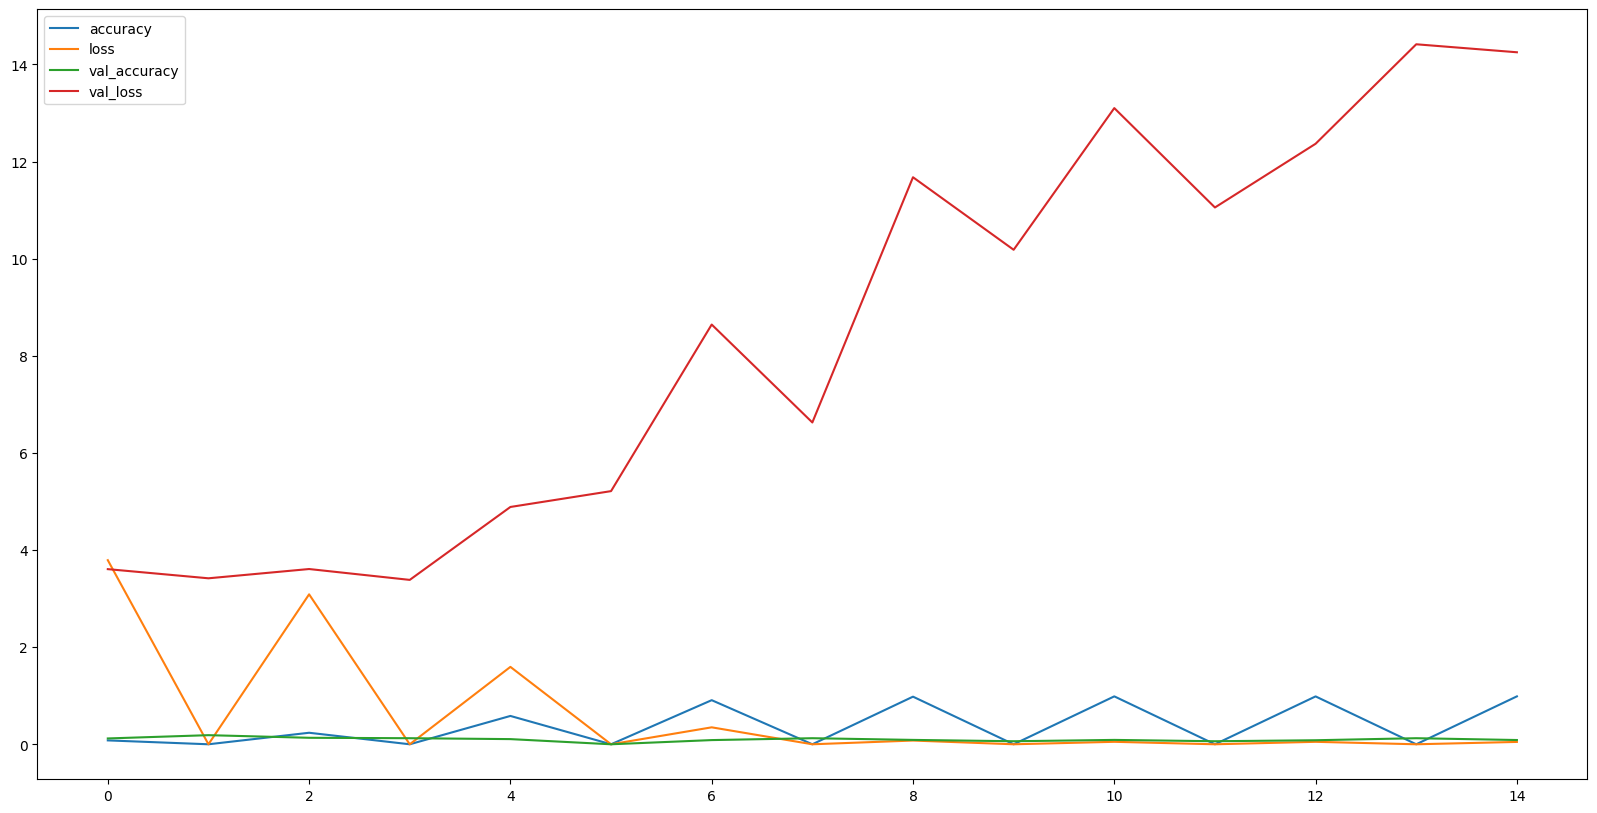

In [ ]:
# Create model
model_1 = Sequential([
    Conv2D(10,3,input_shape=(256,256,3)),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Conv2D(10,3),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(58),
    Activation(activation="softmax")
])

# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=15,
                        steps_per_epoch=train_data.samples // 32,
                        validation_data=val_data,
                        validation_steps=val_data.samples // 32 )

print("Model Summary")
model_1.summary()

print("Model evaluation")
model_1.evaluate(val_data)

# Plot loss and accuracy
pd.DataFrame(history_1.history).plot(figsize=(20, 10))

# Creating the second model, with data augmentation and architecture adjustments


In [ ]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import tensorflow as tf

#Creating our Model Chekpoint callback, one for loss and the other for accuarcy.
filepath_loss = '/content/drive/MyDrive/data/model_checkpoints/loss/model-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

filepath_acc = '/content/drive/MyDrive/data/model_checkpoints/acc/model-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint_acc = ModelCheckpoint(filepath_acc, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Early stopping callback
early_stop_loss = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
early_stop_acc = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=3)

# Adding CSVLogs load later through pandas
log_csv_loss = CSVLogger('/content/drive/MyDrive/data/model_checkpoints/loss/training_loss.csv')
log_csv_acc = CSVLogger('/content/drive/MyDrive/data/model_checkpoints/acc/training_acc.csv')

callbacks_list = [checkpoint_acc, checkpoint_loss, early_stop_acc, early_stop_loss, log_csv_acc]

# Create model
model_2 = Sequential([
    Input(shape=(256, 256, 3)),  # Define input shape here instead of input_shape=(256,256,3)
    Conv2D(32, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(32, 3, padding='same'),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),
    Dropout(0.2), # reduced from 0.25

    Conv2D(64, 3, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Reduced from 0.01
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64, 3, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),
    Dropout(0.2),

    Conv2D(128, 3, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128, 3, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),
    Dropout(0.2),

    Flatten(),
    Dense(256,  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.25), # reduced from 0.5
    Dense(58),
    Activation("softmax")
])

# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=15,
                        steps_per_epoch=train_data.samples // 32,
                        validation_data=val_data,
                        validation_steps=val_data.samples // 32 )

print("Model Summary")
model_2.summary()

print("Model evaluation")
model_2.evaluate(val_data)

# Plot loss and accuracy
pd.DataFrame(history_2.history).plot(figsize=(20, 10))

model_2.save('/content/drive/MyDrive/data/model_checkpoints/model_2.keras')

Epoch 1/15
 897/1450 ━━━━━━━━━━━━━━━━━━━━ 1:51 202ms/step - accuracy: 0.0670 - loss: 5.4122

In [ ]:
class_names = [d for d in os.listdir('/content/20FoodImages/train/') if not d.startswith('.')]
class_names.sort()  # making sure that directories are sorted/stored in the same way
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus']

(-0.5, 511.5, 340.5, -0.5)

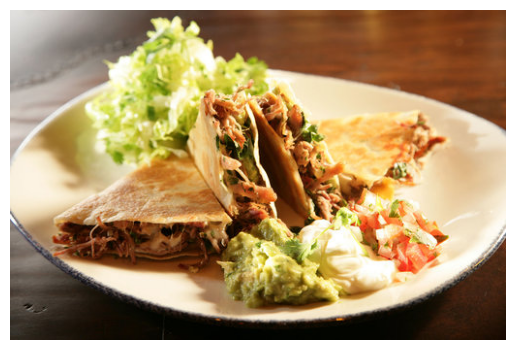

In [ ]:
apple_pie = mpimg.imread("/content/20FoodImages/test/chicken_quesadilla/10257.jpg")
plt.imshow(apple_pie)
plt.axis(False)

In [ ]:
apple_pie.shape

(341, 512, 3)

In [ ]:
apple_pie = normalize_and_resize("/content/20FoodImages/test/apple_pie/101251.jpg")
apple_pie

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.25784314, 0.20686275, 0.07156863],
        [0.26078433, 0.20980392, 0.07892157],
        [0.2622549 , 0.21078432, 0.08382353],
        ...,
        [0.3372549 , 0.38578433, 0.30882353],
        [0.30735293, 0.3602941 , 0.27009803],
        [0.26911765, 0.32794118, 0.22892156]],

       [[0.24901961, 0.20392157, 0.09411765],
        [0.24313726, 0.19803922, 0.09411765],
        [0.24460784, 0.19901961, 0.09901961],
        ...,
        [0.4764706 , 0.5083333 , 0.44411764],
        [0.43039215, 0.4617647 , 0.39313725],
        [0.39068627, 0.42205882, 0.34754902]],

       [[0.2514706 , 0.20833333, 0.12598039],
        [0.2514706 , 0.20833333, 0.13186274],
        [0.25196078, 0.21029411, 0.13529412],
        ...,
        [0.65294117, 0.67058825, 0.6156863 ],
        [0.6127451 , 0.6284314 , 0.5735294 ],
        [0.5377451 , 0.5534314 , 0.4970588 ]],

       ...,

       [[0.39019608, 0.25196078, 0.05343137],
        [0.40

In [ ]:
prediction = model_2.predict(tf.expand_dims(apple_pie, axis=0))
prediction #image probabilites

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[3.5285191e-03, 1.3558094e-06, 8.9643458e-03, 5.0097283e-06,
        3.8463317e-05, 1.0931784e-06, 1.3100264e-04, 3.1148749e-05,
        6.4633804e-04, 3.2222472e-02, 6.0218328e-05, 3.2583339e-04,
        1.5659671e-04, 1.8736660e-05, 1.4913877e-03, 1.2464849e-04,
        5.2773397e-05, 1.2853201e-03, 2.7025603e-03, 3.2617974e-01,
        9.2787857e-08, 1.7590866e-06, 7.4103722e-05, 1.4340236e-06,
        3.1751648e-02, 4.5270866e-04, 3.5268653e-04, 6.2945561e-04,
        1.4185958e-02, 3.6506641e-05, 6.7464849e-03, 3.0536117e-05,
        1.2121843e-04, 2.0010857e-09, 1.7194981e-03, 7.7267055e-04,
        1.2136302e-04, 3.9889437e-05, 7.7601617e-05, 5.7676854e-04,
        2.8457755e-06, 2.3699186e-03, 3.6321479e-05, 1.0971338e-04,
        3.3793963e-02, 8.7886910e-06, 1.9349149e-01, 4.4119116e-03,
        2.4993829e-05, 8.4297173e-03, 1.1696439e-03, 5.8136397e-05,
        5.0649449e-04, 1.3831610e-04, 1.1193346e-07, 2.2003509e-03,
        1.9247395e-03, 3.1566274e-01]], dtype=fl

In [ ]:
class_names[np.argmax(prediction)]

'chicken_quesadilla'

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
# Download ResNet model and save as Keras layer
resnet_layer = hub.KerasLayer(resnet_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
resnet_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    resnet_layer,
    Dense(58,
        activation="softmax")
])

In [ ]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 58)                118842    
                                                                 
Total params: 23683642 (90.35 MB)
Trainable params: 118842 (464.23 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Compile resnet Model
resnet_model.compile(loss="categorical_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [ ]:
# Fit Transfer Learning Model
resnet_history = resnet_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=val_data)

Epoch 1/5
1450/1450 [==============================] - 287s 193ms/step - loss: 1.6775 - accuracy: 0.5630 - val_loss: 1.5066 - val_accuracy: 0.6003
Epoch 2/5
1450/1450 [==============================] - 279s 193ms/step - loss: 1.1749 - accuracy: 0.6792 - val_loss: 1.4679 - val_accuracy: 0.6168
Epoch 3/5
1450/1450 [==============================] - 236s 163ms/step - loss: 1.0062 - accuracy: 0.7219 - val_loss: 1.4717 - val_accuracy: 0.6173
Epoch 4/5
1450/1450 [==============================] - 222s 153ms/step - loss: 0.8990 - accuracy: 0.7490 - val_loss: 1.4916 - val_accuracy: 0.6194
Epoch 5/5
1450/1450 [==============================] - 224s 154ms/step - loss: 0.8135 - accuracy: 0.7714 - val_loss: 1.4884 - val_accuracy: 0.6270


In [ ]:
prediction = resnet_model.predict(tf.expand_dims(apple_pie, axis=0))
prediction #image probabilites

NameError: name 'apple_pie' is not defined

In [ ]:
class_names[np.argmax(prediction)]

'apple_pie'

In [ ]:
eff_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
# Download EfficientNet model and save as Keras layer
# Trainable : False means we don't want to train it further
eff_layer = hub.KerasLayer(eff_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
eff_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    eff_layer,
    # Define we will use 20 classes
    Dense(58,
        activation="softmax")
])

In [ ]:
# Compile EfficientNet Model
eff_model.compile(loss="categorical_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [ ]:
# Fit Transfer Learning Model
eff_history = eff_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=val_data)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-16-5cdd6edc477d>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,20] labels_size=[32,58]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_269574]

In [ ]:
prediction = eff_model.predict(tf.expand_dims(apple_pie, axis=0))
prediction #image probabilites

NameError: name 'apple_pie' is not defined

In [ ]:
class_names[np.argmin(prediction)]

'baby_back_ribs'

In [ ]:
for class_name, probability in zip(class_names, prediction[0]):
    print(f"{class_name}: {probability:.4f}")

apple_pie: 0.2756
baby_back_ribs: 0.0167
baklava: 0.7076
